In [ ]:
import scanpy as sc
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pegasus as pg
import gseapy as gp
import networkx as nx
from statannot import add_stat_annotation
import matplotlib as mpl
from gseapy import barplot
import scipy
import math
import collections as cc
import itertools
from statannotations.Annotator import Annotator
import anndata as ad
import ktplotspy as kpy
import scanpy.external as sce

os.chdir('/home/wangjing/wangj/AgingScore/AgingScorePro/GSE163530_COVID-19_Scripts')

In [ ]:
mm_l2 = pd.read_csv('../l2.csv',index_col=0)
mm_l2.head()

In [ ]:
### load meta data
ClinicMeta = pd.read_csv('/home/wangjing/wangj/AgingScore/GSE163530_COVID-19/GSE162911_GeoMx/ClinicMeta.csv',index_col=0)

In [636]:
### load WTA data
os.chdir('/home/wangjing/wangj/AgingScore/GSE163530_COVID-19/GSE162911_GeoMx/')
input_files = ['Broad-COVID_WTA_Q3Norm_TargetCountMatrix.txt','Broad-COVID_WTA_SegmentProperties.txt','annotation_file_wta.txt']
data = pg.read_input(input_files)
data._inplace_subset_obs(data.obs['Patient_ID'] != 'None')
data._inplace_subset_obs(data.obs['Patient_ID'].isin(['S01','S02','S03','S09','S10','S11','S16','S18','S28']))
data._inplace_subset_obs(data.obs['Primary_Morph'] != 'None')
data.obs['Patient_ID'] = data.obs['Patient_ID'].cat.remove_categories('None')
data.obs['Primary_Morph'] = data.obs['Primary_Morph'].cat.remove_categories('None')
bwhID2broadID = {'S01': 'D18', 'S02': 'D19', 'S03': 'D20', 'S09': 'D21', 'S10': 'D8', 'S11': 'D9', 'S16': 'D10', 'S18': 'D11', 'S28': 'D12'}
data.obs['Broad_ID'] = pd.Categorical(data.obs['Patient_ID'].astype(str).map(lambda x: bwhID2broadID[x]), categories = ['D8', 'D9', 'D10', 'D11', 'D12', 'D18', 'D19', 'D20', 'D21'])

data.obs['Age'] = ClinicMeta.loc[data.obs['Broad_ID'] .values,'Age'].values
data

2023-09-22 14:35:46,704 - pegasusio.readwrite - INFO - nanostring file '['Broad-COVID_WTA_Q3Norm_TargetCountMatrix.txt', 'Broad-COVID_WTA_SegmentProperties.txt', 'annotation_file_wta.txt']' is loaded.
2023-09-22 14:35:46,706 - pegasusio.readwrite - INFO - Function 'read_input' finished in 0.46s.


MultimodalData object with 1 UnimodalData: 'unknown-nanostring'
    It currently binds to NanostringData object unknown-nanostring

NanostringData object with n_obs x n_vars = 309 x 18363
    UID: unknown-nanostring; Genome: unknown; Modality: nanostring
    It contains 1 matrix: 'Q3Norm'
    It currently binds to matrix 'Q3Norm' as X

    obs: 'primer plate well', 'slide name', 'scan name', 'panel', 'segment', 'aoi', 'roi', 'area', 'SequencingSaturation', 'RawReads', 'TrimmedReads', 'StitchedReads', 'AlignedReads', 'DeduplicatedReads', 'Patient_ID', 'Primary_Morph', 'Broad_ID', 'Age'
    uns: 'genome', 'modality', 'uid'

In [637]:
data.log_transform()
data

MultimodalData object with 1 UnimodalData: 'unknown-nanostring'
    It currently binds to NanostringData object unknown-nanostring

NanostringData object with n_obs x n_vars = 309 x 18363
    UID: unknown-nanostring; Genome: unknown; Modality: nanostring
    It contains 2 matrices: 'Q3Norm', 'LogMatrix'
    It currently binds to matrix 'LogMatrix' as X

    obs: 'primer plate well', 'slide name', 'scan name', 'panel', 'segment', 'aoi', 'roi', 'area', 'SequencingSaturation', 'RawReads', 'TrimmedReads', 'StitchedReads', 'AlignedReads', 'DeduplicatedReads', 'Patient_ID', 'Primary_Morph', 'Broad_ID', 'Age'
    uns: 'genome', 'modality', 'uid'

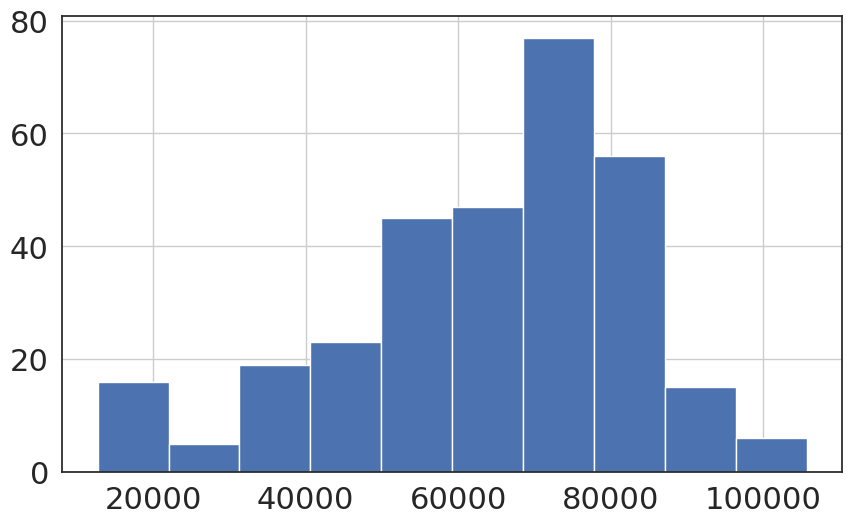

In [638]:
data.obs['log_total_counts'] = data.X.sum(axis = 1)
data.obs.log_total_counts.hist()
plt.show()

In [639]:
### calculate hUSI in ROI
### intersect data
genes = set(mm_l2.index) & set(data.var_names)
exp = data[:,list(genes)].X
l2_fd = mm_l2.loc[list(genes)]
### calsulate hUSI
hUSI= []
for row in exp:
    hUSI.append(pd.Series(list(l2_fd['w'])).corr(pd.Series(row.tolist()),method = 'spearman'))
data.obs['hUSI'] = hUSI

/home/tools/anaconda3/envs/velocyto-env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


In [640]:
data.obs['hUSI'].corr(data.obs['RawReads'],method = 'spearman')

0.0471341218857384

In [659]:
data.obs['DTD'] = ClinicMeta.loc[data.obs['Broad_ID'].values,'Days_to_death'].values

In [642]:
from pegasus.tools import calc_mean, calc_sig_background, predefined_signatures, load_signatures_from_file
data.var["mean"] = calc_mean(data.X, axis = 0)
mean_vec = data.var["mean"].values
n_bins = 50
bins = pd.qcut(mean_vec, n_bins, duplicates = "drop")
bins.categories = bins.categories.astype(str)
data.var["bins"] = bins
data.obsm["sig_bkg_mean"], data.obsm["sig_bkg_std"] = calc_sig_background(data.X, bins, mean_vec)

/tmp/ipykernel_58141/3998562061.py:6: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.


In [643]:
signatures = load_signatures_from_file("lung_spatial_markers.gmt")
for key, gene_list in signatures.items():
    genes = pd.Index(gene_list)
    idx = data.var_names.isin(genes)
    data.obs[key] = ((data.X[:, idx] - data.var.loc[idx, "mean"].values - data.obsm["sig_bkg_mean"][:, data.var["bins"].cat.codes[idx]]) / data.obsm["sig_bkg_std"][:,data.var["bins"].cat.codes[idx]]).mean(axis = 1).astype(np.float32)
    data.register_attr(key, "signature")

2023-09-22 14:36:01,731 - pegasus.tools.utils - INFO - Loaded signatures from GMT file lung_spatial_markers.gmt.


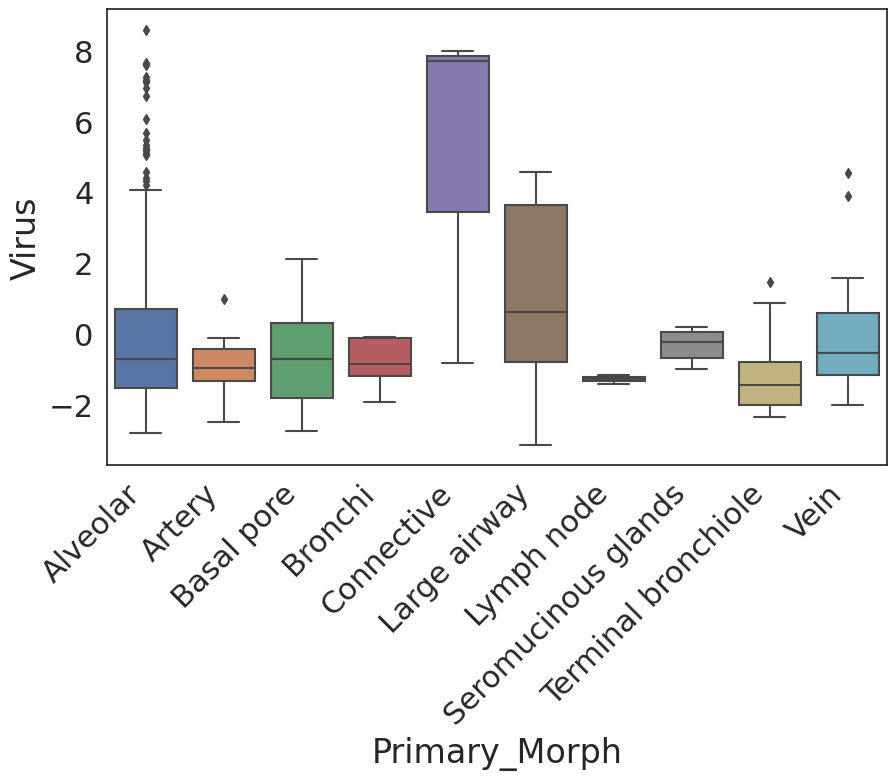

In [685]:
sns.set(font_scale=2,rc={'figure.figsize':(10,6)},style="white")
sns.boxplot(y='Virus', x = 'Primary_Morph',data=data.obs)
plt.xticks(rotation=45, ha='right')
plt.show()

In [657]:
data[data.obs.Primary_Morph == 'Alveolar'].obs.Virus

barcodekey
DSP-1001250001620-A02    0.682415
DSP-1001250001620-A03    0.396863
DSP-1001250001620-A04   -0.851119
DSP-1001250001620-A05   -0.937261
DSP-1001250001620-A06   -1.459761
                           ...   
DSP-1001660004763-H06   -1.310271
DSP-1001660004763-H07   -1.159659
DSP-1001660004763-H10   -1.903587
DSP-1001660004763-H11   -1.649349
DSP-1001660004763-H12   -1.722127
Name: Virus, Length: 190, dtype: float32

In [663]:
data.obs['Virus'].corr(data.obs['hUSI'],method = 'spearman')

-0.2869880226728554

In [664]:
[print(i,scipy.stats.spearmanr(data[data.obs.Primary_Morph == i].obs.hUSI,data[data.obs.Primary_Morph == i].obs.Virus)) for i in data.obs.Primary_Morph.cat.categories]

Alveolar SpearmanrResult(correlation=nan, pvalue=nan)
Artery SpearmanrResult(correlation=-0.7000000000000001, pvalue=0.002535094604431932)
Basal pore SpearmanrResult(correlation=nan, pvalue=nan)
Bronchi SpearmanrResult(correlation=-0.14371515142959107, pvalue=0.7342214747617433)
Connective SpearmanrResult(correlation=-0.5, pvalue=0.6666666666666667)
Large airway SpearmanrResult(correlation=0.22058823529411767, pvalue=0.4116664304979635)
Lymph node SpearmanrResult(correlation=-0.9999999999999999, pvalue=nan)
Seromucinous glands SpearmanrResult(correlation=0.48571428571428577, pvalue=0.3287230320699709)
Terminal bronchiole SpearmanrResult(correlation=-0.052307692307692305, pvalue=0.7996701960899608)
Vein SpearmanrResult(correlation=-0.1411764705882353, pvalue=0.6020026838819791)


[None, None, None, None, None, None, None, None, None, None]

### single cell data

In [ ]:
### load raw scnRNA data
Covid_raw = sc.read_h5ad("/home/wangjing/wangj/AgingScore/GSE163530_COVID-19/GSE171668_scnRNA/lung.h5ad")

In [ ]:
Covid_raw.obs['Donor'] = Covid_raw.obs['donor'].str.split("_").str.get(0)
Covid_raw.obs['Age'] = ClinicMeta.loc[Covid_raw.obs['Donor'].values,'Age'].values
Covid_raw.obs['DTD'] = ClinicMeta.loc[Covid_raw.obs['Donor'].values,'Days_to_death'].values
Covid_raw.obs['IMV'] = ClinicMeta.loc[Covid_raw.obs['Donor'].values,'IMV_days'].values

Covid_raw 

In [ ]:
plt.hist(Covid_raw.X.sum(axis=1).flatten().tolist()[0])

In [ ]:
adata = Covid_raw.copy()

In [ ]:
### remove cells with high ribosome gene expression
adata.obs['percent_ribo'] = adata.raw.X[:,(adata.var_names.str.startswith('RPS') | adata.var_names.str.startswith('RPL'))].sum(axis=1).flatten().tolist()[0]/adata.obs['n_UMI']
sc.set_figure_params(dpi=50, color_map='viridis',figsize=(8,6))
sc.pl.violin(adata, ['percent_ribo'], groupby='Donor')

In [ ]:
adata = adata[adata.obs['percent_ribo']<0.05,:]
sc.pp.normalize_total(adata)
adata

In [ ]:
adata.obs['norm_counts'] = adata.X.sum(axis=1).flatten().tolist()[0]

In [ ]:
### umap plot
sc.pl.umap(adata,color=['Cluster'],legend_loc='right margin',wspace = 0.3,show=False)
plt.show()

In [ ]:
### filter genes with adorable mean expression level
mean_exp = np.array(adata.X.mean(axis=0).flatten().tolist()[0])
features = adata.var_names[mean_exp > np.quantile(mean_exp,0.75)]

In [ ]:
len(features)

In [ ]:
genes = set(mm_l2.index) & set(features) 
mm_l2 = mm_l2.loc[list(genes),]

exp = adata[:,list(genes)].X.todense()
exp = pd.DataFrame(exp,index=adata.obs_names,columns=list(genes))

In [ ]:
### calculate hUSI
hUSI = []
for row in range(len(exp)):  
    hUSI.append(mm_l2.w.corr(exp.iloc[row],method='spearman'))

In [ ]:
adata.obs['hUSI'] = hUSI

In [ ]:
adata.obs['hUSI'].corr(adata.obs['norm_counts'])

In [ ]:
adata.write_h5ad('/home/wangjing/wangj/AgingScore/GSE163530_COVID-19/GSE171668_scnRNA/Covid_Lung.h5ad')
# adata = sc.read_h5ad("/home/wangjing/wangj/AgingScore/GSE163530_COVID-19/GSE171668_scnRNA/Covid_Lung.h5ad")

In [ ]:
### umap plot
sc.pl.umap(adata,color=['hUSI'],legend_loc='right margin',wspace = 0.3,show=False)
plt.show()

In [ ]:
df_plot = adata.obs[['Cluster','Donor','hUSI','DTD','Age','IMV']].copy()
df_plot['Group'] = df_plot['Donor']
df_plot = df_plot.groupby(['Cluster','Group']).mean().reset_index()
df_plot.fillna(0,inplace=True)
mat = df_plot.pivot(index='Cluster',columns='Group',values='hUSI').to_numpy()

In [ ]:
sns.clustermap(mat, cmap='coolwarm', metric='euclidean', method='average',figsize=(8,6),cbar_kws={'label': 'hUSI'},
               xticklabels=df_plot.Group.unique(),
               yticklabels=df_plot.Cluster.cat.categories)
plt.show() 

In [ ]:
label = adata.obs.Cluster.cat.categories.to_list()
corr = [scipy.stats.spearmanr(adata[adata.obs.Cluster == i].obs.hUSI,adata[adata.obs.Cluster == i].obs.DTD) for i in adata.obs.Cluster.cat.categories]

In [ ]:
c = []
p = []
for i in range(len(corr)):
    c.append(corr[i][0])
    if corr[i][1] == 0:
        p.append(260)
    else:
        p.append(-np.log(corr[i][1]))
    print(label[i],c[i],p[i])

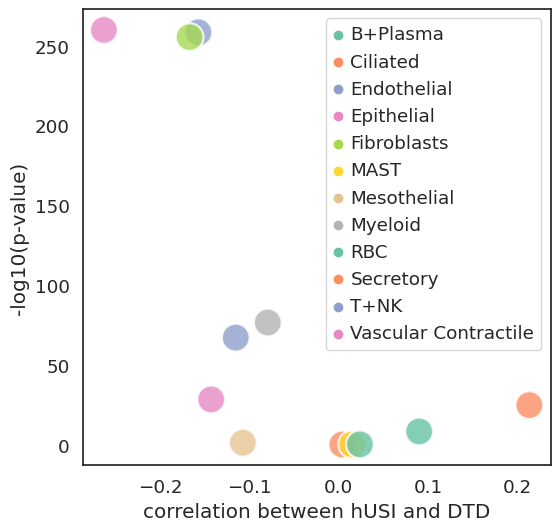

In [688]:
sns.set(rc={'figure.figsize':(6,6)},font_scale=1.2)
sns.set_style("white")
ax = sns.scatterplot(x=c, 
                     y=p, 
                     hue=label,
                     legend='auto',
                     s = 400,
                     alpha=0.8,
                     palette=sns.color_palette("Set2", 12))
plt.xlabel('correlation between hUSI and DTD')
plt.ylabel('-log10(p-value)')
plt.show()

In [ ]:
ClinicMeta.Days_to_death.median()

In [706]:
adata.obs['Progress'] = pd.Categorical(['severe' if i <  15 else 'moderate' for i in adata.obs.DTD],categories=['moderate','severe'],ordered=True)

In [ ]:
adata.obs['Progress'].value_counts()

moderate    66849
severe      32541
Name: Progress, dtype: int64

In [698]:
pd.crosstab(adata.obs.Progress,adata.obs.Cluster)


Cluster,B+Plasma,Ciliated,Endothelial,Epithelial,Fibroblasts,MAST,Mesothelial,Myeloid,RBC,Secretory,T+NK,Vascular Contractile
Progress,,,,,,,,,,,,
moderate,649,2050,12763,17523,11448,61,104,14568,123,933,5074,1553
severe,1009,116,7577,2975,6322,233,1,8695,60,40,4531,982


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Secretory_moderate v.s. Secretory_severe: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.110e+04
T+NK_moderate v.s. T+NK_severe: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.830e-68 U_stat=9.110e+06
Vascular Contractile_moderate v.s. Vascular Contractile_severe: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.635e-22 U_stat=5.830e+05
RBC_moderate v.s. RBC_severe: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.523e+03
Ciliated_moderate v.s. Ciliated_severe: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.561e-06 U_stat=8.441e+04
B+Plasma_moderate v.s. B+Plasma_severe: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.411e+05


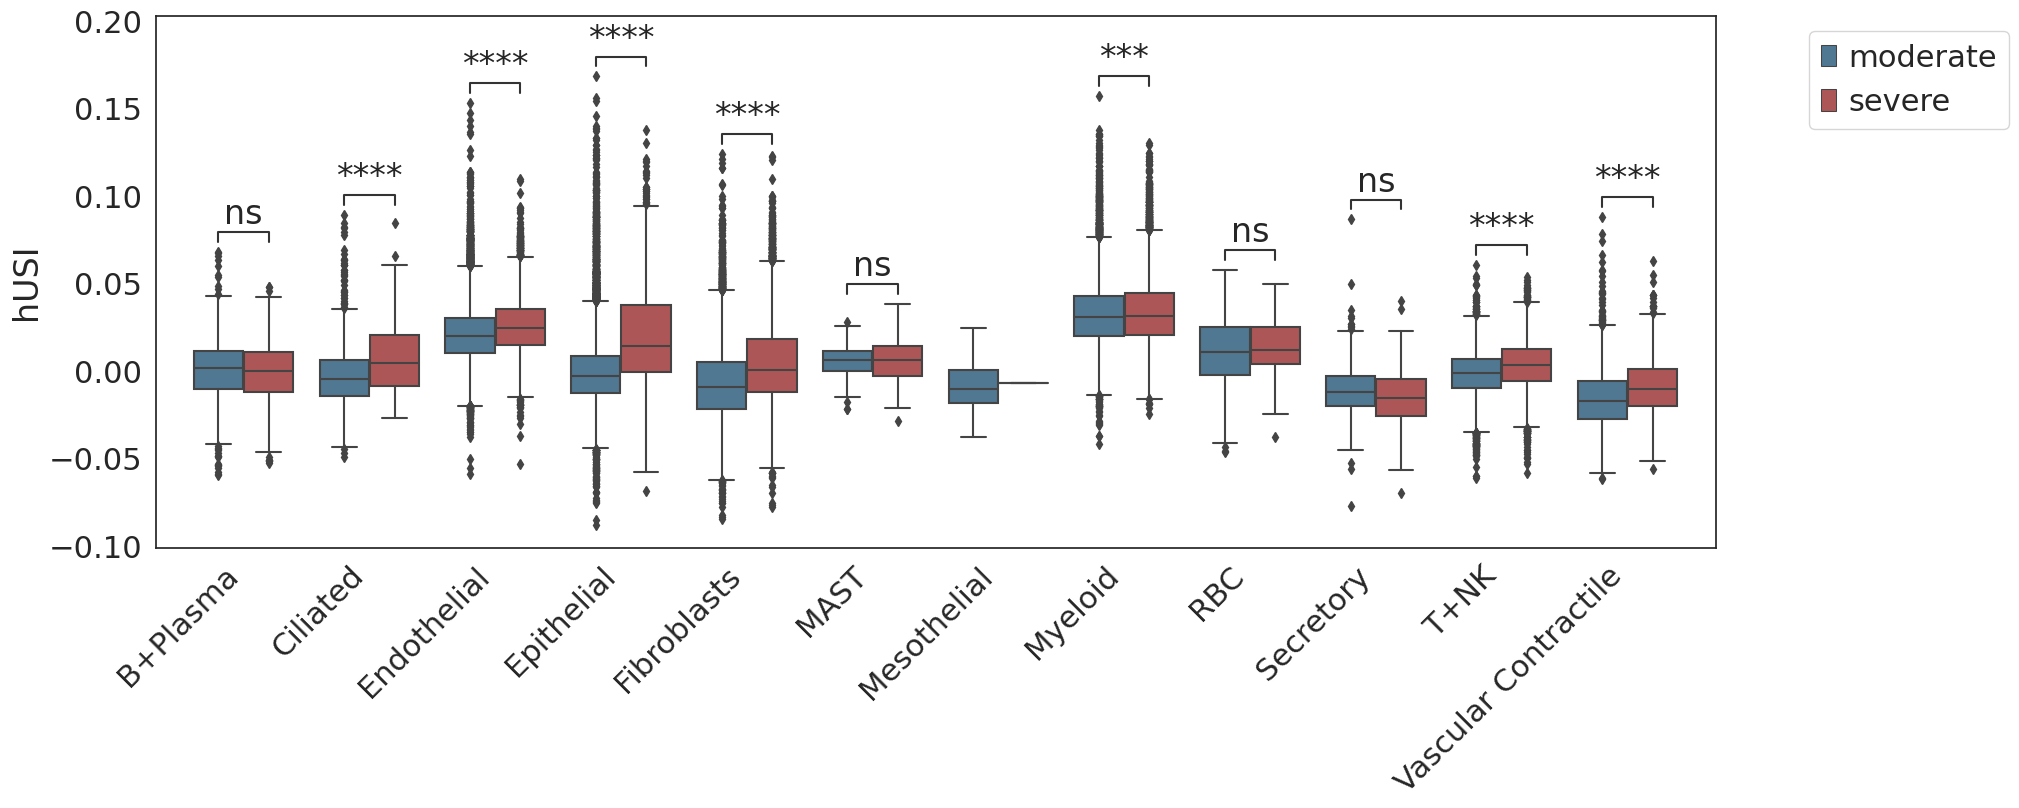

In [713]:
### boxplot significant: hUSI State Clsuter
sns.set(rc={'figure.figsize':(20,7)},font_scale=2)
sns.set_style("white")
ax = sns.boxplot(x='Cluster',hue= 'Progress',y='hUSI',data= adata.obs,palette=['#457b9d',"#bc4749"])
ax.set(xlabel=None)
# ax.set(xticklabels=[])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
pairs = []
for clu in ['B+Plasma', 'Ciliated', 'Endothelial', 'Epithelial', 'Fibroblasts','MAST', 'Myeloid', 'RBC', 'Secretory', 'T+NK','Vascular Contractile']:
    pair = []
    for state in adata.obs.Progress.unique():
        pair.append((clu,state))
    pairs = pairs+list(itertools.combinations(pair, 2))
add_stat_annotation(ax, data=adata.obs, x="Cluster", y="hUSI",hue='Progress',
                    box_pairs=pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2,
                    comparisons_correction = "bonferroni",line_offset_to_box=0.02,line_offset=0.01)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
adata_sub = adata[adata.obs.Cluster == 'Endothelial',:]
# adata_sub.obs['DTD'] = pd.Categorical(adata_sub.obs['DTD'])
sc.pl.violin(adata_sub, ['hUSI'], groupby='Progress')
plt.show()

In [ ]:
###density plot:hUSI State Cluster
sns.displot(adata.obs, x='hUSI',hue = 'Progress',col = 'Cluster', kind="kde")
plt.show()

In [ ]:
### proportion plot
pg.compo_plot(adata, 
              condition = 'State', 
              groupby = 'Cluster', 
              style = 'frequency',
              palette=['#B8E1FF','#7DAAFF','#085EC0'],
              panel_size=(5,5))

In [ ]:
## calculate correlation 
print(scipy.stats.spearmanr(adata.obs['State'], adata.obs['Age']))
print(scipy.stats.spearmanr(adata.obs['State'], adata.obs['DTD']))

In [ ]:
### correlation point plot: Age DTD propotion of each State
Cluster = adata.obs.Cluster.cat.categories
df = adata.obs[['Donor','Cluster','State']]
df = df.groupby(['Donor','Cluster','State']).size()
df = df.reset_index()
df['%'] = 100 * (df[0] / df.groupby(['Donor','Cluster'])[0].transform('sum'))
df['DTD'] = ClinicMeta.loc[df['Donor'].values,'Days_to_death'].values
df['Age'] = ClinicMeta.loc[df['Donor'].values,'Age'].values
corr_DTD_c = []
corr_Age_c = []
corr_DTD_p = []
corr_Age_p = []

state = 'State_3'

for cluster in Cluster:
        data = df[(df.Cluster == cluster) & (df.State == state)]
        corr = scipy.stats.spearmanr(data['DTD'],data['%'])
        corr_DTD_c.append(corr[0])
        corr_DTD_p.append(corr[1])
        corr = scipy.stats.spearmanr(data['Age'],data['%'])
        corr_Age_c.append(corr[0])
        corr_Age_p.append(corr[1])        
import math
data = pd.DataFrame([corr_DTD_c,corr_Age_c,Cluster,[(i+j)/2 for i,j in zip(corr_DTD_p,corr_Age_p)]]).T
data.columns = ['Corr_DTD','Corr_Age','Cluster','Mean_Pvalue']
data
sns.set(rc={'figure.figsize':(5,5)},font_scale=1)
sns.set_style("white")
ax = sns.scatterplot(data=data, 
                     x='Corr_DTD', 
                     y='Corr_Age', 
                     hue="Cluster", 
                     legend='auto', 
                     size='Mean_Pvalue', 
                     sizes=(200, 100))
h,l = ax.get_legend_handles_labels()
plt.legend(h[0:5],l[0:6],bbox_to_anchor=(0.45, 0.48), loc=2, borderaxespad=0.)
plt.show(ax.set(title=state+' Cells Percentage'))

In [ ]:
### State DEGs
adata.layers['X_norm'] = adata.X
sc.tl.rank_genes_groups(adata,groupby='State',
                        method='wilcoxon',
                        groups = ['State_3'],
                        reference='State_1',
                        key_added='State_DEGs',
                        layer='X_norm',
                        use_raw= False)
df = sc.get.rank_genes_groups_df(adata,group='State_3',key='State_DEGs',pval_cutoff=0.05)
cc.Counter(df['logfoldchanges']>0)

In [ ]:
### heatmap plot: SASP
SASP = pd.read_csv('./../SASP.csv')
UpGenes = sc.get.rank_genes_groups_df(adata,group='State_3',key='State_DEGs',pval_cutoff=0.05,log2fc_min = 0.5)
UpGenes = UpGenes[UpGenes.names.isin(SASP['Symbol'])].sort_values(by = 'scores',ascending=False)

kwargs = dict(vmin = 0,vmax =4)
pg.heatmap(adata, 
           attrs=UpGenes.names, 
           attrs_cluster=False, 
           groupby='State',
           groupby_cluster=False,
           switch_axes=True,
           dpi=100,
           on_average=True,
           panel_size = (6,8),**kwargs)

In [ ]:
### choos enrichment gene list
names = gp.get_library_name()
list(filter(lambda x: 'GO' in x, names))

In [ ]:
### filter DEGs
df = sc.get.rank_genes_groups_df(adata,group='State_3',key='State_DEGs',pval_cutoff=0.05)
degs_up = df[(df.logfoldchanges > 0)]
print(degs_up.shape)
degs_up.head()

In [ ]:
### GO Enrich_GOment analysis
enr_GO = gp.enrichr(gene_list=degs_up.names, background='hsapiens_gene_ensembl', cutoff=0.05,
                 gene_sets=[ 'GO_Biological_Process_2021', 'GO_Cellular_Component_2021','GO_Molecular_Function_2021'])
Enrich_GO = enr_GO.results
Enrich_GO = Enrich_GO[Enrich_GO['Adjusted P-value']<0.05]
Enrich_GO.to_csv('Enrich_GO_State.csv')

In [ ]:
### barplot 
Enrich_GO.Term = [s.split(' (')[0] for s in Enrich_GO.Term]
sns.set_style("whitegrid")
ax = barplot(Enrich_GO,
              column="Adjusted P-value",
              group='Gene_set', 
              top_term=10,
              figsize=(6,10),
              color=['#FF745A', '#007E99','#FFA8A8'])

In [ ]:
### KEGG Enrich_KEGGment analysis
enr_KEGG = gp.enrichr(degs_up.names,
                    gene_sets='KEGG_2021_Human',
                    outdir=None)
Enrich_KEGG = enr_KEGG.results 
Enrich_KEGG = Enrich_KEGG[Enrich_KEGG['Adjusted P-value']<0.05]
Enrich_KEGG.to_csv('Enrich_KEGG_State.csv')

In [ ]:
Enrich_KEGG= pd.read_csv('Enrich_KEGG_State.csv')

In [ ]:
Enrich_KEGG = Enrich_KEGG[(Enrich_KEGG.Term.isin(['Cellular senescence','Coronavirus disease']))|
                          (Enrich_KEGG.Term.isin(list(filter(lambda x: 'signaling pathway' in x, Enrich_KEGG.Term))))]
Enrich_KEGG

In [ ]:
### network plot:KEGG enrichment
nodes, edges = gp.enrichment_map(Enrich_KEGG,top_term = 20)
G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])
node_list = sorted(G.nodes())
angle = []
angle_dict = {}
n = 20
for i, node in zip(range(n),node_list):
    theta = 2.0*np.pi*i/n
    angle.append((np.cos(theta),np.sin(theta)))
    angle_dict[node] = theta
pos = {}
for node_i, node in enumerate(node_list):
    pos[node] = angle[node_i]

labels = nodes.Term.to_dict()

fig, ax = plt.subplots(figsize=(8,8))
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
ax.axis('equal')

edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()

net = nx.draw(G,pos=pos,with_labels=False, ax=ax,width=list(map(lambda x: x*10, edge_weight)),edge_color='#CDDBD4',
        node_color=list(nodes['Adjusted P-value']),
        node_size=list(nodes.Hits_ratio *1000),cmap=plt.cm.RdYlBu)
description = nx.draw_networkx_labels(G,pos,labels=labels,font_size=10)

r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    bbdata = bb.transformed(trans)
    radius = 1.2+bbdata.width/2.
    position = (radius*np.cos(angle_dict[node]),radius* np.sin(angle_dict[node]))
    t.set_position(position)
    t.set_rotation(angle_dict[node]*360.0/(2.0*np.pi))
    t.set_clip_on(False)
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu, 
                           norm=plt.Normalize(vmin = nodes['Adjusted P-value'].min(), 
                                              vmax=nodes['Adjusted P-value'].max()))
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax_col = fig.add_axes([0.1, 0.04, 0.02, 0.15])
sns.set(font_scale=1)
ax_col.set_title('Adjusted P-value')
plt.colorbar(sm,shrink=0.4,cax=ax_col,orientation='vertical')
# plt.savefig("./figures/Enrich_2.png",dpi = 200,bbox_inches = 'tight')
# plt.show()

In [ ]:
### Cluster and SubCluster State
CluState = []
[CluState.append(cluster + "_" + state) for cluster,state, in zip(adata.obs.Cluster.values,adata.obs.State.values)]
adata.obs['CluState'] = pd.Categorical(CluState)
SubState = []
[SubState.append(subcluster + "_" + state) for subcluster,state, in zip(adata.obs.SubCluster.values,adata.obs.State.values)]
adata.obs['SubState'] = pd.Categorical(SubState)

In [ ]:
### Cluster State DEGs
for clu in adata.obs.Cluster.cat.categories:
    sc.tl.rank_genes_groups(adata,
                            groupby='CluState',
                            method='wilcoxon',
                            groups=[clu+'_State_3'],
                            reference=clu+'_State_1',
                            key_added=clu+'_DEGs',
                            layer='X_norm',
                            use_raw=False)
    
[print(sc.get.rank_genes_groups_df(adata,group=clu+'_State_3',key=clu+'_DEGs',pval_cutoff=0.05,log2fc_min=2).shape) for clu in adata.obs.Cluster.cat.categories]

In [ ]:
### SubCluster state DEGs
for sub in adata.obs.SubCluster.cat.categories:
    sc.tl.rank_genes_groups(adata,
                            groupby='SubState',
                            method='wilcoxon',
                            groups=[sub+'_State_3'],
                            reference=sub+'_State_1',
                            key_added=sub+'_DEGs',
                            layer='X_norm',
                            use_raw=False)
    
[print(sc.get.rank_genes_groups_df(adata,group=sub+'_State_3',key=sub+'_DEGs',pval_cutoff=0.05,log2fc_min=2).shape) for sub in adata.obs.SubCluster.cat.categories]

In [ ]:
adata

In [ ]:
# adata.write_h5ad('./Covid_Lung.h5ad')
adata = sc.read_h5ad('./Covid_Lung.h5ad')

In [ ]:
### barplot: CluState DEGs Enrichment
CluDEGs_Enrich = pd.DataFrame()
for clu in adata.obs.Cluster.cat.categories:
    df = pd.DataFrame(sc.queries.enrich(adata, 
                            org="hsapiens",
                            gprofiler_kwargs={'sources':['GO:CC']},
                            group=clu+'_State_3',
                            key=clu+'_DEGs',
                            pval_cutoff=0.05,
                            log2fc_min=2)).head(5)
    df['cluster'] = clu
    CluDEGs_Enrich = pd.concat([CluDEGs_Enrich,df])
CluDEGs_Enrich.head()

In [ ]:
### bar plot 
sns.set(rc={'figure.figsize':(12,15)},font_scale=1.5)
sns.set_style("white")
ax = sns.barplot(x=[-math.log10(i) for i in CluDEGs_Enrich.p_value],y = CluDEGs_Enrich.name,ci = None,hue=CluDEGs_Enrich.cluster)
plt.ylabel(ylabel=None)
plt.xlabel(xlabel='-log10(p-value)',size = 20)
ax.set_title('GO:CC Pathway Enrichment')
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.show()

In [ ]:
### run cellphoneDB
### cell type
adata.obs['CluState'].values.describe()
df_meta = pd.DataFrame(data={'Cell':list(adata.obs.index),
                             'cell_type':[ i for i in adata.obs['CluState']]
                            })
df_meta.set_index('Cell', inplace=True)
df_meta.to_csv('cp_meta.tsv', sep = '\t')

### run in linux
# source activate cpdb
# nohup cellphonedb method degs_analysis cp_meta.tsv State2.h5ad cp_DEGs.tsv --counts-data hgnc_symbol --threshold 0.1 > cp.log 2>&1 &
# nohup cellphonedb method statistical_analysis cp_meta.tsv Covid_Lung.h5ad --counts-data hgnc_symbol --threshold 0.1 --output-path cpdb_out> cp.log 2>&1 &

In [ ]:
means = pd.read_csv('cpdb_out_Cluster/means.txt', sep = '\t')
pvals = pd.read_csv('cpdb_out_Cluster/pvalues.txt', sep = '\t')
decon = pd.read_csv('cpdb_out_Cluster/deconvoluted.txt', sep = '\t')

In [ ]:
### total heatmap plot
kpy.plot_cpdb_heatmap(
        adata=adata,
        pvals=pvals,
        celltype_key="SubState",
        figsize = (10,10),
        title = "Sum of significant interactions",
        symmetrical = True,
        vmin=0,vmax = 100)

In [ ]:
### chemokines plot
df = kpy.plot_cpdb(
        adata=adata,
        cell_type1='.',
        cell_type2='.',
        means=means,
        pvals=pvals,
        celltype_key="CluState",
        gene_family = "chemokines",
        figsize = (25,5),
        highlight_size = 1,
        keep_significant_only = True,
        return_table=True
    )
df = df.loc[-df.significant.isna(),]
df = df.sort_values(by = 'scaled_means',ascending=False).head(10)
df.celltype_group = df.celltype_group.cat.remove_unused_categories()
sns.set(rc={'figure.figsize':(5,5)},font_scale=1.5)
sns.set_style("whitegrid")
plt.scatter(x='interaction_group',
            y = 'celltype_group',
            data=df,c='scaled_means',
            s=[-math.log10(i)*200 for i in df.pvals],
            cmap='OrRd',vmin=0.9,vmax=1)
plt.colorbar(label='scaled_means')
plt.xticks(rotation = 90)
plt.title("Chemokines")
plt.show()

In [ ]:
df = pvals.iloc[:,11:pvals.shape[1]]
counts = (df!=1).sum(axis = 0)
counts = counts.sort_values(ascending=False)[1:30]
counts_top = cc.Counter([i[1] for i in [s.split('|') for s in counts.index]])
counts_top 

In [ ]:
cluDict = ['Endothelial','Epithelial','Fibroblasts','Myeloid']

In [ ]:
Type = cluDict[0]

df = kpy.plot_cpdb(
        adata=adata,
        cell_type1='Myeloid_State_3',
        cell_type2=Type+'_State_1|'+Type+'_State_2|'+Type+'_State_3',
        means=means,
        pvals=pvals,
        celltype_key="CluState",
        keep_significant_only = True,
        return_table=True)

df_1 = df.loc[[Type+'_State_3' in s for s in df.celltype_group] & (df.significant == 'yes')]
df_2 = df.loc[[(Type+'_State_1' in s)|(Type+'_State_2' in s) for s in df.celltype_group] & (df.significant == 'yes')]
interactions = df_1.interaction_group[~(df_1.interaction_group.isin(df_2.interaction_group))]
print(interactions)
interactions_exclude = df.interaction_group[~(df.interaction_group.isin(interactions))]

In [ ]:
kpy.plot_cpdb(
        adata=adata,
        cell_type1='Myeloid_State_3',
        cell_type2=Type+'_State_1|'+Type+'_State_2|'+Type+'_State_3',
        means=means,
        pvals=pvals,
        celltype_key="CluState",
        exclude_interactions = list(interactions_exclude),
        keep_significant_only = True,
        figsize = (10,10)
)

In [ ]:
### trajectory
adata_sub = adata[adata.obs.Cluster == 'Endothelial']
adata_sub

In [ ]:
exp = adata_sub.X.todense()
exp = pd.DataFrame(exp,index=adata_sub.obs_names,columns=adata_sub.var_names)
exp.head()

In [ ]:
cor = []
for col in range(exp.shape[1]):  
    cor.append(adata_sub.obs.hUSI.corr(exp.iloc[:,col],method='pearson'))
adata_sub.var['cor_hUSI'] = cor

In [ ]:
features = adata_sub.var['cor_hUSI'].sort_values(ascending = False)[0:1500].index.values
features

In [ ]:
adata_defeature = adata_sub[:,features]
adata_defeature

In [ ]:
sc.tl.pca(adata_defeature, svd_solver='arpack',n_comps=10)

In [ ]:
sc.pp.neighbors(adata_defeature, n_neighbors=10, n_pcs=10)
sc.tl.draw_graph(adata_defeature)

In [ ]:
sc.pl.draw_graph(adata_defeature, color='CluState', legend_loc='on data')